In [1]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import LightningModule, Trainer
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
import torch
import math
import timm

import transforms.eft as Eft
from datasets.transformed_dataset import TransformedDataset
from utils import plot_confusion_matrix
from models.radio_rec_model import RadioRecNetwork
from models.resnet import create_resnet_2d
import datasets.signal_file_dataset as sfds

In [2]:
print(torch.cuda.is_available())

True


In [3]:
root = "/home/zwlin/data/radiorec/ALE2G_link11/link11"
sig_file_set = sfds.SignalFileSet(root, 'wav')
sig_file_set.print_info()

data path: /home/zwlin/data/radiorec/ALE2G_link11/link11
classes: ['link11_ceshi', 'link11_dianming', 'link11_wangluo', 'link11_yingda']
class dict: {'link11_ceshi': 0, 'link11_dianming': 1, 'link11_wangluo': 2, 'link11_yingda': 3}
{'link11_ceshi': 1, 'link11_dianming': 1, 'link11_wangluo': 1, 'link11_yingda': 1}


In [4]:
import datasets.signal_file_dataset as sfds
sig_file_conf = sfds.SignalFileConfig()
sig_file_conf.fs = 48000      # 48K Hz sample rate
sig_file_conf.seg_len = 500   # 500ms ???
sig_file_conf.seg_shift = 500 # 500 ms, no overlap
sig_file_conf.max_num = 2000
sig_file_conf.is_complex = True
sig_file_conf.energy_threshold = 0.0

sig_dataset = sfds.SignalDataSet(sig_file_set, sig_file_conf)
sig_dataset.print_info()

class list: ['link11_ceshi', 'link11_dianming', 'link11_wangluo', 'link11_yingda']
class dict: {'link11_ceshi': 0, 'link11_dianming': 1, 'link11_wangluo': 2, 'link11_yingda': 3}
seg count for each class: {'link11_ceshi': 1082, 'link11_dianming': 1087, 'link11_wangluo': 1158, 'link11_yingda': 1081}


In [5]:
sig_dataset.save('/home/zwlin/data/radiorec/link11.hdf5')

In [6]:
sig_dataset = sfds.SignalDataSet()
sig_dataset.load('/home/zwlin/data/radiorec/link11.hdf5')
sig_dataset.print_info()

class list: ['link11_ceshi', 'link11_dianming', 'link11_wangluo', 'link11_yingda']
class dict: {'link11_ceshi': 0, 'link11_dianming': 1, 'link11_wangluo': 2, 'link11_yingda': 3}
seg count for each class: {'link11_ceshi': 1082, 'link11_dianming': 1087, 'link11_wangluo': 1158, 'link11_yingda': 1081}


In [7]:
sig_dataset.data.shape

(4408, 24000, 1)

In [8]:
sig_dataset.labels.shape

(4408,)

In [9]:
class_list = sig_dataset.class_list
num_classes = len(class_list)

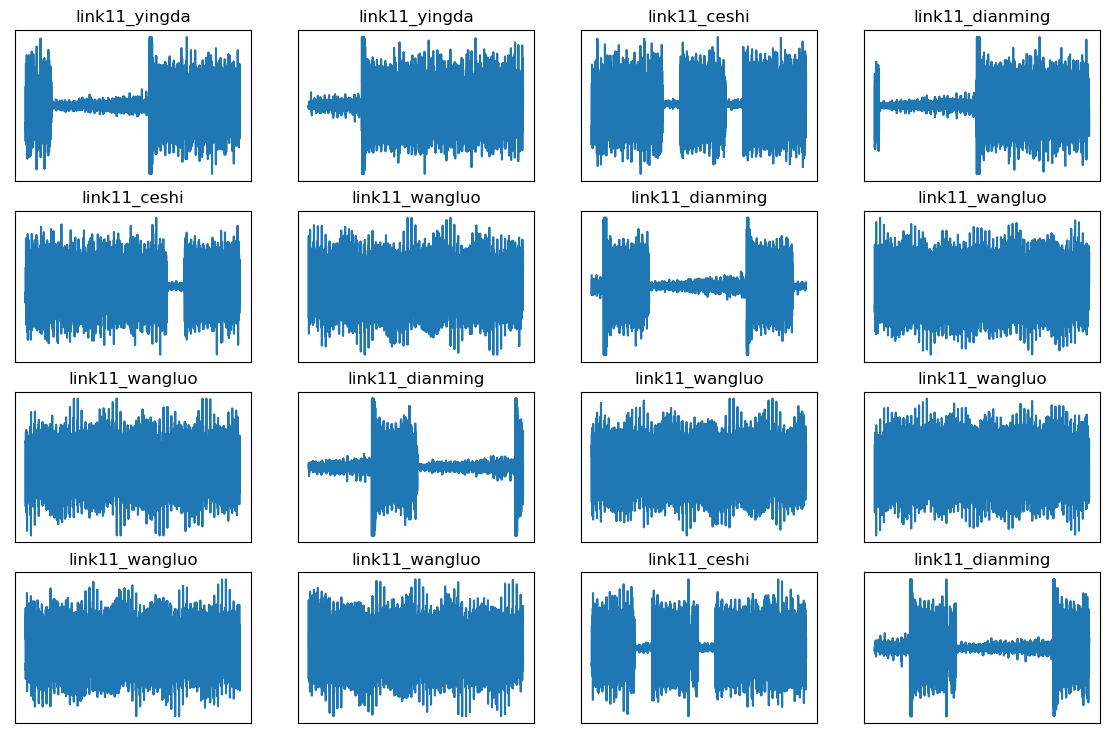

In [10]:
# Repeat but plot andom sampling of the data
from datasets.visualize import TimeSeriesVisualizer

example_dataloader = DataLoader(
    dataset=sig_dataset,
    batch_size=16,
    num_workers=10,
    shuffle=True,
    drop_last=True,
)
visualizer = TimeSeriesVisualizer(
    data_loader = example_dataloader,
    visualize_target_transform = lambda target: [class_list[int(index)] for index in target]
)

for figure in iter(visualizer):
    figure.set_size_inches(14, 9)
    plt.show()
    break

In [11]:
from transforms.transforms import Compose
from transforms.spectrogram_transform import SpectrogramConfig, Spectrogram

interleave_to_complex = Eft.InterleaveComplex()

spectrogram_config = SpectrogramConfig()
spectrogram_config.nperseg = 256
spectrogram_config.noverlap = 128
spectrogram_config.nfft = 256
spectrogram_config.window = 'hann'
spectrogram_config.return_onesided = False
spectrogram_config.mode = 'magnitude'

spectorgram_transform = Spectrogram(spectrogram_config)

ds = TransformedDataset(sig_dataset, transform = Compose([interleave_to_complex, spectorgram_transform]))

In [12]:
num_total = len(ds)
num_train = math.floor(0.8 * num_total)
num_val = math.floor(0.1 * num_total)
num_test = num_total - num_train - num_val

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(ds, [num_train, num_val, num_test],
                                                                         generator = torch.Generator().manual_seed(42))
idx = np.random.randint(len(train_dataset))
data, label = train_dataset[idx]
channels = data.shape[0]
print("Dataset length: {}".format(len(ds)))
print("Data shape: {}".format(data.shape))
print(f"Channels: {channels}")
print("Label Index: {}".format(label))
print("Label Class: {}".format(class_list[label]))

Dataset length: 4408
Data shape: (1, 256, 186)
Channels: 1
Label Index: 2
Label Class: link11_wangluo


In [13]:
# ----
# ### Format Dataset for Training
# Next, the datasets are then wrapped as `DataLoaders` to prepare for training.

# Create dataloaders
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    num_workers=8,
    shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=16,
    num_workers=8,
    shuffle=False,
    drop_last=False,
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=16,
    num_workers=8,
    shuffle=False,
    drop_last=False,
)

In [14]:
model = create_resnet_2d(name = 'resnet18', pretrained = False, num_classes = num_classes, in_chans = channels)
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [16]:
# Training Config
learning_rate=0.002
epochs = 50

radiorec_model = RadioRecNetwork(model, learning_rate = learning_rate)

In [17]:
# ----
# ### Train the Model
# To train the model, we first create a `ModelCheckpoint` to monitor the validation loss over time and save the best model as we go. The network is then instantiated and passed into a `Trainer` to kick off training.
import os
checkpoint_dir=f'exp/radiorec/link11-checkpoints'
if not os.path.exists(checkpoint_dir):
    print(f'mkdir: {checkpoint_dir}')
    os.makedirs(checkpoint_dir)

In [18]:
# Setup checkpoint callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename='{epoch}-{val_loss:.2f}',
    save_top_k=3,
    save_last=True,
    verbose=True,
    monitor="val_loss",
    mode="min",
)

In [19]:
# Create and fit trainer

trainer = Trainer(
    max_epochs=epochs, callbacks=checkpoint_callback, devices=1, accelerator="gpu"
)

trainer.fit(radiorec_model, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/zwlin/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:608: UserWarning: Checkpoint directory /home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/link11-checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | mdl  | ResNet | 11.2 M
--------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.689    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 220: 'val_loss' reached 0.48333 (best 0.48333), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/link11-checkpoints/epoch=0-val_loss=0.48.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 440: 'val_loss' reached 0.40927 (best 0.40927), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/link11-checkpoints/epoch=1-val_loss=0.41.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 660: 'val_loss' reached 2.28395 (best 0.40927), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/link11-checkpoints/epoch=2-val_loss=2.28.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 880: 'val_loss' reached 0.12962 (best 0.12962), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/link11-checkpoints/epoch=3-val_loss=0.13.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 1100: 'val_loss' reached 0.06308 (best 0.06308), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/link11-checkpoints/epoch=4-val_loss=0.06.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 1320: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 1540: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 1760: 'val_loss' reached 0.04253 (best 0.04253), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/link11-checkpoints/epoch=7-val_loss=0.04.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 1980: 'val_loss' reached 0.04126 (best 0.04126), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/link11-checkpoints/epoch=8-val_loss=0.04.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 2200: 'val_loss' reached 0.05704 (best 0.04126), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/link11-checkpoints/epoch=9-val_loss=0.06.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 2420: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 2640: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 2860: 'val_loss' reached 0.03964 (best 0.03964), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/link11-checkpoints/epoch=12-val_loss=0.04.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 3080: 'val_loss' reached 0.03405 (best 0.03405), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/link11-checkpoints/epoch=13-val_loss=0.03.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 3300: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 3520: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 3740: 'val_loss' reached 0.03280 (best 0.03280), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/link11-checkpoints/epoch=16-val_loss=0.03.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 3960: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 4180: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 4400: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 4620: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 4840: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 5060: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 5280: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 5500: 'val_loss' reached 0.03808 (best 0.03280), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/link11-checkpoints/epoch=24-val_loss=0.04.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 5720: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 5940: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 6160: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 6380: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 6600: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 6820: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 7040: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 7260: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 7480: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 7700: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 7920: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 8140: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 8360: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 8580: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 8800: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 40, global step 9020: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 41, global step 9240: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 42, global step 9460: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 43, global step 9680: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 44, global step 9900: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 45, global step 10120: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 46, global step 10340: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 47, global step 10560: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 48, global step 10780: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 49, global step 11000: 'val_loss' was not in top 3


In [20]:
checkpoint_callback.best_model_path

'/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/link11-checkpoints/epoch=16-val_loss=0.03.ckpt'

In [21]:
# After the model is trained, the checkpoint's weights are loaded into the model and the model is put into evaluation mode. The validation set is looped through, inferring results for each example and saving the predictions and the labels. Finally, the labels and predictions are passed into our confusion matrix plotting function to view the results and also passed into the `sklearn.metrics.classification_report` method to print metrics of interest.
checkpoint_filename = checkpoint_callback.best_model_path
# checkpoint_filename = 'exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=26-val_loss=0.13.ckpt'

# Load best checkpoint
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = torch.load(
    checkpoint_filename, map_location=lambda storage, loc: storage
)

model = create_resnet_2d(name = 'resnet18', pretrained = False, num_classes = num_classes, in_chans = channels)
test_model = RadioRecNetwork(model, learning_rate = learning_rate)
test_model.load_state_dict(checkpoint["state_dict"])
test_model = test_model.to(device=device).eval()

In [22]:
# ### Evaluate the val set

# Infer results over validation set
num_val_examples = len(val_dataset)
y_raw_preds = np.empty((num_val_examples, num_classes))
y_preds = np.zeros((num_val_examples,))
y_true = np.zeros((num_val_examples,))

for i in tqdm(range(0, num_val_examples)):
    # Retrieve data
    idx = i  # Use index if evaluating over full dataset
    data, label = val_dataset[idx]
    # Infer
    data = torch.from_numpy(np.expand_dims(data, 0)).float().to(device)
    pred_tmp = test_model.predict(data)
    pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp
    # Argmax
    y_preds[i] = np.argmax(pred_tmp)
    # Store label
    y_true[i] = label

100%|████████████████████████████████████████| 440/440 [00:01<00:00, 253.83it/s]


Val set classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        93
         1.0       1.00      0.93      0.96        98
         2.0       1.00      1.00      1.00       123
         3.0       0.95      1.00      0.97       126

    accuracy                           0.98       440
   macro avg       0.99      0.98      0.98       440
weighted avg       0.98      0.98      0.98       440



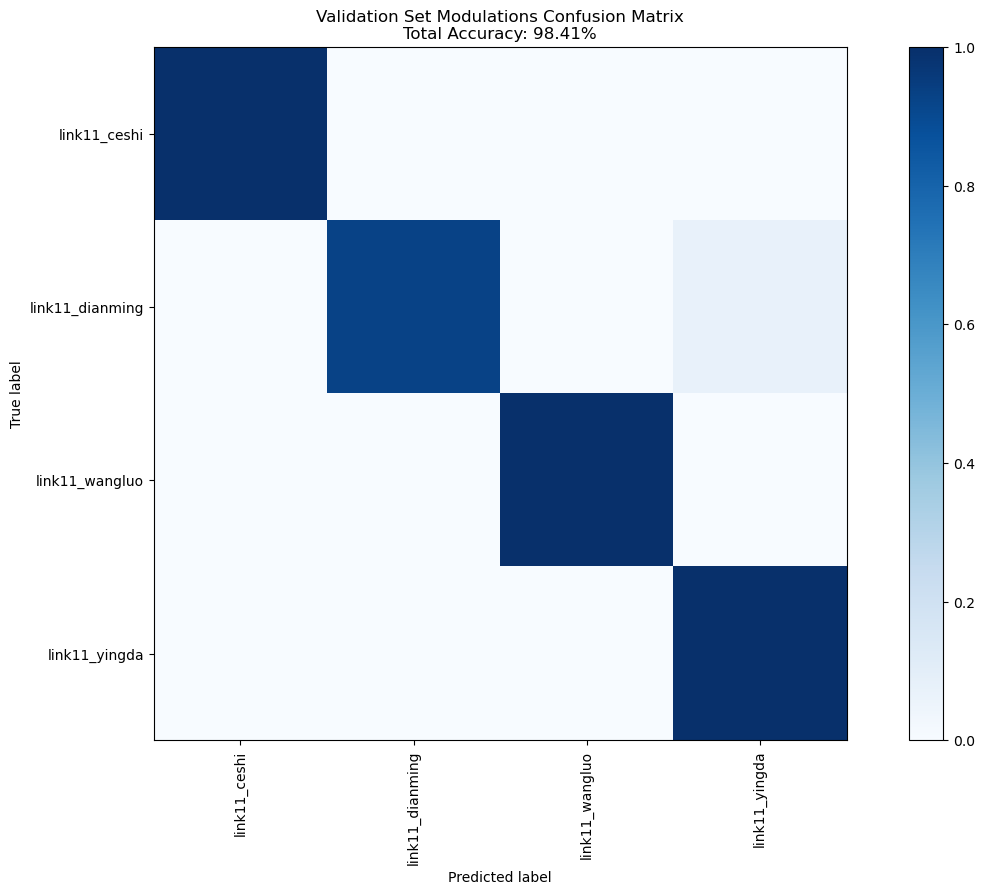

In [23]:
acc = np.sum(np.asarray(y_preds) == np.asarray(y_true)) / len(y_true)
plot_confusion_matrix(
    y_true,
    y_preds,
    classes = class_list,
    normalize = True,
    title="Validation Set Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(
        acc * 100
    ),
    text=False,
    rotate_x_text=90,
    figsize=(16, 9),
)
plt.savefig(f"{checkpoint_dir}/val_result.png")

print("Val set classification report:")
print(classification_report(y_true, y_preds))

100%|████████████████████████████████████████| 442/442 [00:01<00:00, 271.77it/s]


Test set classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       110
         1.0       0.99      0.92      0.95       112
         2.0       1.00      1.00      1.00       129
         3.0       0.91      0.99      0.95        91

    accuracy                           0.98       442
   macro avg       0.97      0.98      0.98       442
weighted avg       0.98      0.98      0.98       442



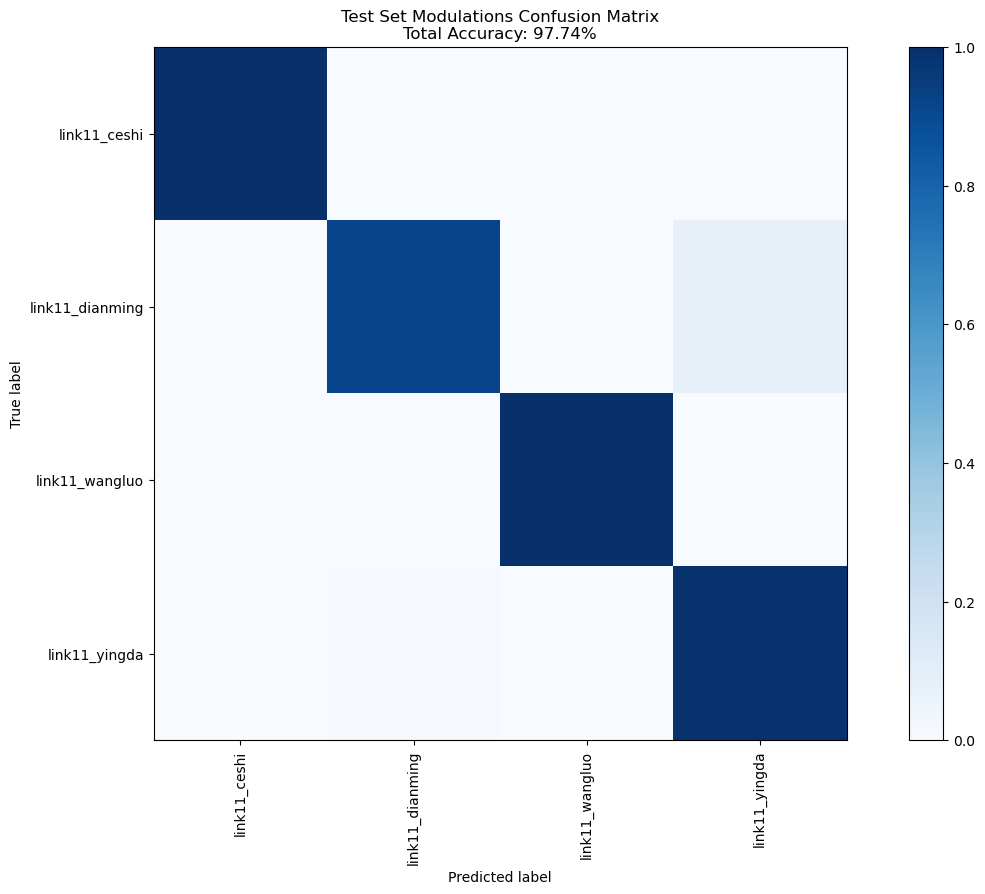

In [24]:
# ----
# ### Evaluate the test set

# Infer results over validation set
num_test_examples = len(test_dataset)
y_raw_preds = np.empty((num_test_examples, num_classes))
y_preds = np.zeros((num_test_examples,))
y_true = np.zeros((num_test_examples,))

for i in tqdm(range(0, num_test_examples)):
    # Retrieve data
    idx = i  # Use index if evaluating over full dataset
    data, label = test_dataset[idx]
    # Infer
    data = torch.from_numpy(np.expand_dims(data, 0)).float().to(device)
    pred_tmp = test_model.predict(data)
    pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp
    # Argmax
    y_preds[i] = np.argmax(pred_tmp)
    # Store label
    y_true[i] = label

acc = np.sum(np.asarray(y_preds) == np.asarray(y_true)) / len(y_true)
plot_confusion_matrix(
    y_true,
    y_preds,
    classes = class_list,
    normalize = True,
    title="Test Set Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(
        acc * 100
    ),
    text=False,
    rotate_x_text=90,
    figsize=(16, 9),
)
plt.savefig(f"{checkpoint_dir}/test_result.png")

print("Test set classification report:")
print(classification_report(y_true, y_preds))